# Unified Model with Multiple Strategic Agents: Asymmetric Network Analysis

James Yu, 13 November 2022

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol = 300):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    max_distances = defaultdict(list)
    counter = 0
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        cd_K = [np.max(np.abs(K_t[l] - K_new[l])) for l in range(L)]
        cd_k = [np.max(np.abs(k_t[l] - k_new[l])) for l in range(L)]
        cd_kappa = [np.max(np.abs(kappa_t[l] - kappa_new[l])) for l in range(L)]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new
        historical_K.insert(0, K_t)
        historical_k.insert(0, k_t)
        historical_kappa.insert(0, kappa_t)
        for l in range(L):
            max_distances[(l+1, "K")].append(cd_K[l])
            max_distances[(l+1, "k")].append(cd_k[l])
            max_distances[(l+1, "kappa")].append(cd_kappa[l])
        counter += 1
        if sum(cd_K + cd_k + cd_kappa) == 0 or counter > tol:
            return max_distances, historical_K, historical_k, historical_kappa

In [5]:
def optimal(X_init, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c, infinite = True):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(lambda: 0)
    i = 0
    while [i < len(historical_K), True][infinite]:
        K_t = historical_K[[i, 0][infinite]]
        k_t = historical_k[[i, 0][infinite]]
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if infinite == True and np.max(X_t[l] - X_new) == 0 and l == L - 1:
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

The objective is to determine whether the agenda-averaging property of the limit opinions continues to hold with asymmetric networks.

In [6]:
def run_simulation(b, symmetric = True, print_ = True):
    if symmetric:
        A = np.array([ # stubborn
            [0.9, 0.07, 0.03],
            [0.07, 0.58, 0.35],
            [0.03, 0.35, 0.62]
        ])
        if print_: print("SYMMETRIC NETWORK")
    else:
        A = np.array([ # asymmetric
            [0.6, 0.3, 0.1],
            [0.4, 0.1, 0.5],
            [0.5, 0.2, 0.3]
        ])
        if print_: print("ASYMMETRIC NETWORK")
    X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T
    X_0 = [X_0_1, X_0_1 - b]
    delta = 0.9 # discount rate
    n = 3 # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [200 * np.identity(n), 200 * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [np.identity(n), np.identity(n)] # direct message broadcasting
    x = [0, b] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
    xs, rs, payoffs = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)
    if print_:
        print("Steady-State Opinions:")
        print(xs[0][-1])
        print("Average of agendas:")
        print(b/2)
        print()
        print("K^* (1, 2):")
        print(historical_K[0][0])
        print(historical_K[0][1])
        print()
        print("k^* (1, 2):")
        print(historical_k[0][0])
        print("sum:", sum(historical_k[0][0][0]))
        print(historical_k[0][1])
        print("sum:", sum(historical_k[0][1][0]))
        print()
        print("kappa^* (1, 2):")
        print(historical_kappa[0][0])
        print(historical_kappa[0][1])
    return sum(historical_k[0][0][0]), sum(historical_k[0][1][0])

## Symmetric Runs:

In [7]:
run_simulation(5)

SYMMETRIC NETWORK
Steady-State Opinions:
[[2.5]
 [2.5]
 [2.5]]
Average of agendas:
2.5

K^* (1, 2):
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]

k^* (1, 2):
[[10.8445118 10.8445118 10.8445118]]
sum: 32.53353540958234
[[-10.8445118 -10.8445118 -10.8445118]]
sum: -32.53353540958234

kappa^* (1, 2):
[[-44.55788635]]
[[-44.55788635]]


(32.53353540958234, -32.53353540958234)

In [8]:
run_simulation(6)

SYMMETRIC NETWORK
Steady-State Opinions:
[[3.]
 [3.]
 [3.]]
Average of agendas:
3.0

K^* (1, 2):
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]

k^* (1, 2):
[[13.01341416 13.01341416 13.01341416]]
sum: 39.04024249149883
[[-13.01341416 -13.01341416 -13.01341416]]
sum: -39.04024249149887

kappa^* (1, 2):
[[-64.16335634]]
[[-64.16335634]]


(39.04024249149883, -39.04024249149887)

In [9]:
run_simulation(728)

SYMMETRIC NETWORK
Steady-State Opinions:
[[364.]
 [364.]
 [364.]]
Average of agendas:
364.0

K^* (1, 2):
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]

k^* (1, 2):
[[1578.96091855 1578.96091855 1578.96091855]]
sum: 4736.88275563519
[[-1578.96091855 -1578.96091855 -1578.96091855]]
sum: -4736.882755635193

kappa^* (1, 2):
[[-944598.67355035]]
[[-944598.67355036]]


(4736.88275563519, -4736.882755635193)

In [10]:
run_simulation(-634)

SYMMETRIC NETWORK
Steady-State Opinions:
[[-317.]
 [-317.]
 [-317.]]
Average of agendas:
-317.0

K^* (1, 2):
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]

k^* (1, 2):
[[-1375.08409665 -1375.08409665 -1375.08409665]]
sum: -4125.2522899350415
[[1375.08409665 1375.08409665 1375.08409665]]
sum: 4125.252289935046

kappa^* (1, 2):
[[-716412.39061105]]
[[-716412.39061105]]


(-4125.2522899350415, 4125.252289935046)

In [11]:
run_simulation(0)

SYMMETRIC NETWORK
Steady-State Opinions:
[[1.3e-322]
 [1.3e-322]
 [1.3e-322]]
Average of agendas:
0.0

K^* (1, 2):
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]

k^* (1, 2):
[[0. 0. 0.]]
sum: 0.0
[[0. 0. 0.]]
sum: 0.0

kappa^* (1, 2):
[[-0.]]
[[-0.]]


(0.0, 0.0)

## Asymmetric Runs:

In [12]:
run_simulation(5, symmetric = False)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[2.5]
 [2.5]
 [2.5]]
Average of agendas:
2.5

K^* (1, 2):
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]

k^* (1, 2):
[[17.627771    7.64775173  7.99120817]]
sum: 33.266730896574884
[[-17.627771    -7.64775173  -7.99120817]]
sum: -33.26673089657485

kappa^* (1, 2):
[[-50.71519228]]
[[-50.71519228]]


(33.266730896574884, -33.26673089657485)

In [13]:
run_simulation(6, symmetric = False)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[3.]
 [3.]
 [3.]]
Average of agendas:
3.0

K^* (1, 2):
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]

k^* (1, 2):
[[21.1533252   9.17730208  9.5894498 ]]
sum: 39.92007707588985
[[-21.1533252   -9.17730208  -9.5894498 ]]
sum: -39.92007707588985

kappa^* (1, 2):
[[-73.02987688]]
[[-73.02987688]]


(39.92007707588985, -39.92007707588985)

In [14]:
run_simulation(728, symmetric = False)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[364.]
 [364.]
 [364.]]
Average of agendas:
364.0

K^* (1, 2):
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]

k^* (1, 2):
[[2566.60345742 1113.51265186 1163.51990926]]
sum: 4843.636018541301
[[-2566.60345742 -1113.51265186 -1163.51990926]]
sum: -4843.6360185413

kappa^* (1, 2):
[[-1075129.6185127]]
[[-1075129.6185127]]


(4843.636018541301, -4843.6360185413)

In [15]:
run_simulation(-634, symmetric = False)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[-317.]
 [-317.]
 [-317.]]
Average of agendas:
-317.0

K^* (1, 2):
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]

k^* (1, 2):
[[-2235.20136264  -969.73491934 -1013.2851957 ]]
sum: -4218.2214776856945
[[2235.20136264  969.73491934 1013.2851957 ]]
sum: 4218.221477685696

kappa^* (1, 2):
[[-815411.03304796]]
[[-815411.03304796]]


(-4218.2214776856945, 4218.221477685696)

In [16]:
run_simulation(0, symmetric = False)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[5.e-323]
 [5.e-323]
 [5.e-323]]
Average of agendas:
0.0

K^* (1, 2):
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]

k^* (1, 2):
[[0. 0. 0.]]
sum: 0.0
[[0. 0. 0.]]
sum: 0.0

kappa^* (1, 2):
[[-0.]]
[[-0.]]


(0.0, 0.0)

Note that, again, $5e-323$ is $5\cdot 10^{-323}$ in scientific notation, which is zero when accounting for floating-point error.

From this we observe that the opinions continue to be the average of the agendas. The $k$ steady-state matrix for a given agent is the negative of the opponent's $k$ matrix.

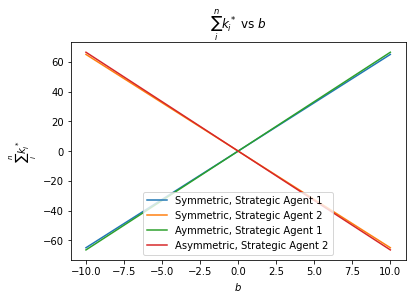

In [17]:
grid = np.linspace(-10, 10, 30)
generate_grid_symmetric = [run_simulation(i, print_ = False) for i in grid]
generate_grid_asymmetric = [run_simulation(i, symmetric = False, print_ = False) for i in grid]
plt.plot(grid, [i[0] for i in generate_grid_symmetric], label = "Symmetric, Strategic Agent 1")
plt.plot(grid, [i[1] for i in generate_grid_symmetric], label = "Symmetric, Strategic Agent 2")
plt.plot(grid, [i[0] for i in generate_grid_asymmetric], label = "Aymmetric, Strategic Agent 1")
plt.plot(grid, [i[1] for i in generate_grid_asymmetric], label = "Asymmetric, Strategic Agent 2")
plt.xlabel("$b$")
plt.ylabel("$\sum_i^n k_i^*$")
plt.title("$\sum_i^n k_i^*$ vs $b$")
plt.legend()
plt.show()

## What if we allow the second agenda to change as well?

In [18]:
def run_simulation_both(a, b, symmetric = True, print_ = True):
    if symmetric:
        A = np.array([ # stubborn
            [0.9, 0.07, 0.03],
            [0.07, 0.58, 0.35],
            [0.03, 0.35, 0.62]
        ])
        if print_: print("SYMMETRIC NETWORK")
    else:
        A = np.array([ # asymmetric
            [0.6, 0.3, 0.1],
            [0.4, 0.1, 0.5],
            [0.5, 0.2, 0.3]
        ])
        if print_: print("ASYMMETRIC NETWORK")
    X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T
    X_0 = [X_0_1 - a, X_0_1 - b]
    delta = 0.9 # discount rate
    n = 3 # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [200 * np.identity(n), 200 * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [np.identity(n), np.identity(n)] # direct message broadcasting
    x = [a, b] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
    xs, rs, payoffs = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)
    if print_:
        print("Steady-State Opinions:")
        print(xs[0][-1] + a)
        print("Average of agendas:")
        print((a+b)/2)
        print()
        print("K^* (1, 2):")
        print(historical_K[0][0])
        print(historical_K[0][1])
        print()
        print("k^* (1, 2):")
        print(historical_k[0][0])
        print("sum:", sum(historical_k[0][0][0]))
        print(historical_k[0][1])
        print("sum:", sum(historical_k[0][1][0]))
        print()
        print("kappa^* (1, 2):")
        print(historical_kappa[0][0])
        print(historical_kappa[0][1])
    return sum(historical_k[0][0][0]), sum(historical_k[0][1][0])

In [19]:
run_simulation_both(-5, 5)

SYMMETRIC NETWORK
Steady-State Opinions:
[[1.68753900e-14]
 [1.24344979e-14]
 [1.15463195e-14]]
Average of agendas:
0.0

K^* (1, 2):
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]

k^* (1, 2):
[[21.68902361 21.68902361 21.68902361]]
sum: 65.06707081916468
[[-21.68902361 -21.68902361 -21.68902361]]
sum: -65.06707081916468

kappa^* (1, 2):
[[-178.2315454]]
[[-178.2315454]]


(65.06707081916468, -65.06707081916468)

In [20]:
run_simulation_both(-5, 5, symmetric = False)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[1.77635684e-15]
 [1.77635684e-15]
 [8.88178420e-16]]
Average of agendas:
0.0

K^* (1, 2):
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]

k^* (1, 2):
[[35.255542   15.29550346 15.98241634]]
sum: 66.53346179314977
[[-35.255542   -15.29550346 -15.98241634]]
sum: -66.5334617931498

kappa^* (1, 2):
[[-202.8607691]]
[[-202.8607691]]


(66.53346179314977, -66.5334617931498)

In [21]:
run_simulation_both(-4, 6)

SYMMETRIC NETWORK
Steady-State Opinions:
[[1.]
 [1.]
 [1.]]
Average of agendas:
1.0

K^* (1, 2):
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]
[[3.78777267 1.14352889 1.03448866]
 [1.14352889 2.91545084 1.90681049]
 [1.03448866 1.90681049 3.02449107]]

k^* (1, 2):
[[21.68902361 21.68902361 21.68902361]]
sum: 65.06707081916471
[[-21.68902361 -21.68902361 -21.68902361]]
sum: -65.06707081916474

kappa^* (1, 2):
[[-178.2315454]]
[[-178.2315454]]


(65.06707081916471, -65.06707081916474)

In [22]:
run_simulation_both(-4, 6, symmetric = False)

ASYMMETRIC NETWORK
Steady-State Opinions:
[[1.]
 [1.]
 [1.]]
Average of agendas:
1.0

K^* (1, 2):
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]
[[4.97479444 1.71234484 1.85435939]
 [1.71234484 1.74409832 0.77104524]
 [1.85435939 0.77104524 1.98564254]]

k^* (1, 2):
[[35.255542   15.29550346 15.98241634]]
sum: 66.53346179314977
[[-35.255542   -15.29550346 -15.98241634]]
sum: -66.53346179314983

kappa^* (1, 2):
[[-202.8607691]]
[[-202.8607691]]


(66.53346179314977, -66.53346179314983)

Here $a$ is the first strategic agent's agenda and $b$ is the second.

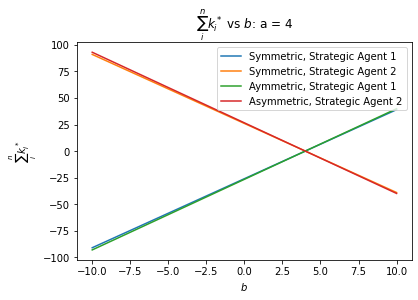

In [23]:
grid = np.linspace(-10, 10, 30)
generate_grid_symmetric = [run_simulation_both(4, i, print_ = False) for i in grid]
generate_grid_asymmetric = [run_simulation_both(4, i, symmetric = False, print_ = False) for i in grid]
plt.plot(grid, [i[0] for i in generate_grid_symmetric], label = "Symmetric, Strategic Agent 1")
plt.plot(grid, [i[1] for i in generate_grid_symmetric], label = "Symmetric, Strategic Agent 2")
plt.plot(grid, [i[0] for i in generate_grid_asymmetric], label = "Aymmetric, Strategic Agent 1")
plt.plot(grid, [i[1] for i in generate_grid_asymmetric], label = "Asymmetric, Strategic Agent 2")
plt.xlabel("$b$")
plt.ylabel("$\sum_i^n k_i^*$")
plt.title("$\sum_i^n k_i^*$ vs $b$: a = 4")
plt.legend()
plt.show()

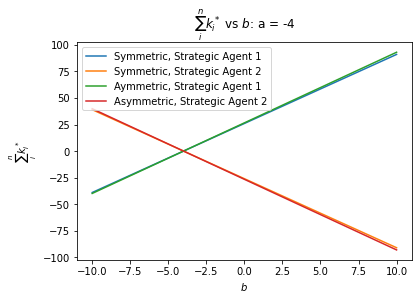

In [24]:
grid = np.linspace(-10, 10, 30)
generate_grid_symmetric = [run_simulation_both(-4, i, print_ = False) for i in grid]
generate_grid_asymmetric = [run_simulation_both(-4, i, symmetric = False, print_ = False) for i in grid]
plt.plot(grid, [i[0] for i in generate_grid_symmetric], label = "Symmetric, Strategic Agent 1")
plt.plot(grid, [i[1] for i in generate_grid_symmetric], label = "Symmetric, Strategic Agent 2")
plt.plot(grid, [i[0] for i in generate_grid_asymmetric], label = "Aymmetric, Strategic Agent 1")
plt.plot(grid, [i[1] for i in generate_grid_asymmetric], label = "Asymmetric, Strategic Agent 2")
plt.xlabel("$b$")
plt.ylabel("$\sum_i^n k_i^*$")
plt.title("$\sum_i^n k_i^*$ vs $b$: a = -4")
plt.legend()
plt.show()

Linearity is observed.

Some printouts for the $\sum_i^n k_i^*$ in the symmetric case:

In [25]:
run_simulation_both(-4, 10, print_ = False)

(91.09389914683058, -91.09389914683052)

In [26]:
run_simulation_both(4, -10, print_ = False)

(-91.09389914683058, 91.09389914683052)

In [27]:
run_simulation_both(0, 10, print_ = False)

(65.06707081916468, -65.06707081916468)

In [28]:
run_simulation_both(-4, 10-4, print_ = False)

(65.06707081916471, -65.06707081916474)

In [29]:
run_simulation_both(0+28, 10+28, print_ = False)

(65.06707081916446, -65.06707081916478)

In [30]:
run_simulation_both(7, -5, print_ = False)

(-78.08048498299767, 78.0804849829976)

In [31]:
run_simulation_both(7-28, -5-28, print_ = False)

(-78.08048498299769, 78.08048498299782)

$\sum_i^n k_i^*$ is constant in parallel shifts to $a$ and $b$.

In [32]:
run_simulation_both(7+2, -5, print_ = False)

(-91.09389914683061, 91.09389914683052)

In [33]:
run_simulation_both(7, -5-2, print_ = False)

(-91.09389914683061, 91.09389914683061)

In [34]:
run_simulation_both(7, 5, print_ = False)

(-13.01341416383299, 13.013414163832948)

In [35]:
run_simulation_both(7+2, 5, print_ = False)

(-26.026828327665868, 26.026828327665875)

In [36]:
run_simulation_both(7, 5-2, print_ = False)

(-26.026828327665896, 26.02682832766584)

Shifts have the same effect when used in opposite directions on opposite agents.

Hence $\sum_i^n k_i^*$ is linear in $a$ and $b$ but of opposite sign factors.

In [37]:
run_simulation_both(0, 0, print_ = False)

(0.0, 0.0)

In [38]:
run_simulation_both(1, 0, print_ = False)

(-6.506707081916467, 6.506707081916463)

These are the slopes.

Checking if the results still hold for the asymmetric case:

In [39]:
run_simulation_both(4, 7, symmetric = False, print_ = False)

(19.960038537944897, -19.960038537944865)

In [40]:
run_simulation_both(4+3, 7+3, symmetric = False, print_ = False)

(19.960038537944992, -19.960038537944925)

In [41]:
run_simulation_both(4-127, 7-127, symmetric = False, print_ = False)

(19.96003853794533, -19.960038537945373)

In [42]:
run_simulation_both(4+54, 7, symmetric = False, print_ = False)

(-339.3206551450638, 339.32065514506377)

In [43]:
run_simulation_both(4, 7-54, symmetric = False, print_ = False)

(-339.3206551450638, 339.3206551450642)

In [44]:
run_simulation_both(0, 0, symmetric = False, print_ = False)

(0.0, 0.0)

In [45]:
run_simulation_both(1, 0, symmetric = False, print_ = False)

(-6.653346179314977, 6.653346179314977)